σᶜʳ (CR, 17 GHz) = 160.1229 m²
σᶜʳ (Boule) = 0.0730 m²
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 7 non reconnu dans leg_dict
[WARNING] Mois 7 non reconnu dans leg_dict
[WARNING] Mois 7 non reconnu dans leg_dict
[WARNING] Mois 7 non reconnu dans leg_dict
[WARNING] Mois 7 non reconnu dans leg_dict
[WARNING] Mois 7 non reconnu dans leg_dict
[WARNING] Mois 7 non reconnu dans leg_dict
[WARNING] Mois 7 non reconnu dans leg_dict
[WARNING] Mois 7 non reconnu dans leg_dict
[WARNING] Mois 7 non reconnu dans leg_dict
[WARNING] Mois 7 non reconnu da

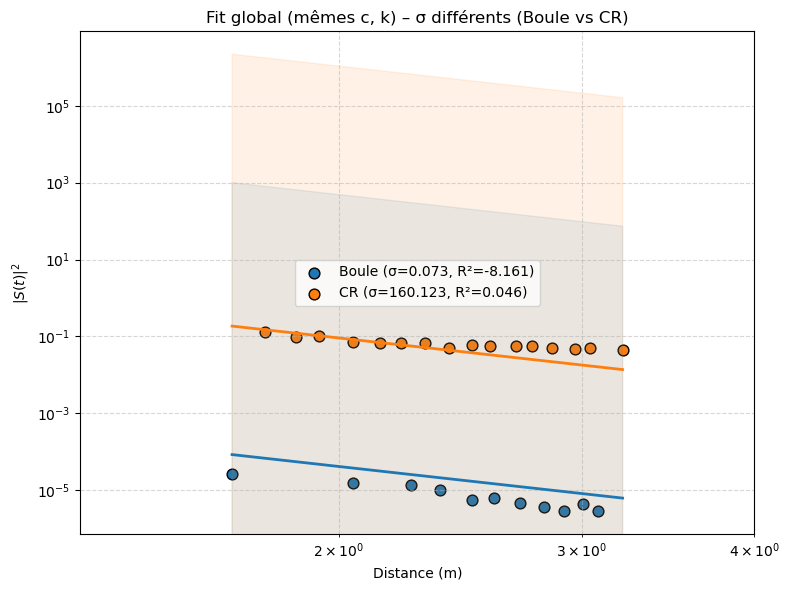

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import glob
from radar import RadarMesure

# -------------------------
# Paramètres
# -------------------------
c = 299792458
f = 17e9
lambdaa = c / f
pad_factor = 4

# RCS de référence :
r_cr = 0.3302  # rayon de la sphère CR en mètres
sigmacr_CR = (4 * np.pi * r_cr**4) / (3 * lambdaa**2)
sigmacr_boule = 0.073  # m²

print(f"σᶜʳ (CR, 17 GHz) = {sigmacr_CR:.4f} m²")
print(f"σᶜʳ (Boule) = {sigmacr_boule:.4f} m²")

# -------------------------
# Fonctions utilitaires
# -------------------------
def bin_to_dist(x, pad_factor=1):
    c = 299792458
    B = 2e9
    ramptime = 102400e-9
    fe = 10e6
    df = fe / 1024
    fb = x * df
    dist = fb * c * ramptime / (2 * B)
    return dist / pad_factor

# Modèle paramétrique (σ dépend du jeu)
def model(R, ccalib, k, sigma):
    return (ccalib * sigma / (R**4)) *k

# -------------------------
# Charger les jeux
# -------------------------
data_boule = glob.glob('/home/nicolas/Documents/Dku-toolbox/data/caliboule/17*.txt')
data_cr    = glob.glob('/home/nicolas/Documents/Dku-toolbox/data/newcod/17*.txt')
data_boule.sort()
data_cr.sort()

ri_boule = [RadarMesure(f, beta=2, pad_factor=pad_factor) for f in data_boule]
ri_cr    = [RadarMesure(f, beta=2, pad_factor=pad_factor) for f in data_cr]

# -------------------------
# Extraction des pics
# -------------------------
def extract_peaks(ri_list, seuil):
    pic = []
    for i in ri_list:
        df = i.df
        peaks, prop = find_peaks(df.copol.loc[1:5], height=seuil)
        if len(peaks) > 0:
            dist = bin_to_dist(peaks[0], pad_factor) + 1
            val = prop['peak_heights'][0]**2
            pic.append((dist, val))
    if not pic:
        return np.array([]), np.array([])
    dfpic = pd.DataFrame(pic).sort_values(by=[0])
    return np.asarray(dfpic[0]), np.asarray(dfpic[1])

X_boule, y_boule = extract_peaks(ri_boule, 0.001)
X_cr, y_cr = extract_peaks(ri_cr, 0.1)

if len(X_boule) == 0 or len(X_cr) == 0:
    raise RuntimeError("Erreur : un des jeux ne contient pas de pics.")

# -------------------------
# Fit global avec σ différents
# -------------------------
def joint_model(X_all, ccalib, k):
    """Concatène les deux modèles en un seul pour le fit."""
    Xb, Xc = X_all[:len(X_boule)], X_all[len(X_boule):]
    yb = model(Xb, ccalib, k, sigmacr_boule)
    yc = model(Xc, ccalib, k, sigmacr_CR)
    return np.concatenate([yb, yc])



def joint_model_k_diff(X_all, ccalib, k_boule, k_cr):
    Xb, Xc = X_all[:len(X_boule)], X_all[len(X_boule):]
    yb = model(Xb, ccalib, k_boule, sigmacr_boule)
    yc = model(Xc, ccalib, k_cr, sigmacr_CR)
    return np.concatenate([yb, yc])



# Données combinées
X_all = np.concatenate([X_boule, X_cr])
y_all = np.concatenate([y_boule, y_cr])

# Fit (mêmes c et k, mais σ interne différent)
bounds = ([0, 0], [5, 10])
popt, pcov = curve_fit(lambda R, c, k: joint_model(R, c, k), X_all, y_all)#, bounds=bounds)
ccalib_shared, k_shared = popt
perr = np.sqrt(np.diag(pcov))

print(f"\nRésultats fit global :")
print(f"  c_calib = {ccalib_shared:.3e} ± {perr[0]:.1e}")
print(f"  k       = {k_shared:.3f} ± {perr[1]:.3f}")

# -------------------------
# Évaluation séparée
# -------------------------
def evaluate(X, y, sigma, c, k):
    y_pred = model(X, c, k, sigma)
    r2 = r2_score(y, y_pred)
    return y_pred, r2

y_pred_boule, r2_boule = evaluate(X_boule, y_boule, sigmacr_boule, ccalib_shared, k_shared)
y_pred_cr, r2_cr = evaluate(X_cr, y_cr, sigmacr_CR, ccalib_shared, k_shared)

print(f"\nÉvaluation séparée :")
print(f"  Boule : R² = {r2_boule:.4f}")
print(f"  CR    : R² = {r2_cr:.4f}")

# -------------------------
# Visualisation
# -------------------------
x_fit = np.linspace(min(X_all), max(X_all), 400)
y_fit_boule = model(x_fit, ccalib_shared, k_shared, sigmacr_boule)
y_fit_cr    = model(x_fit, ccalib_shared, k_shared, sigmacr_CR)

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(X_boule, y_boule, color='tab:blue', edgecolors='k', s=60, label=f'Boule (σ={sigmacr_boule:.3f}, R²={r2_boule:.3f})')
ax.scatter(X_cr, y_cr, color='tab:orange', edgecolors='k', s=60, label=f'CR (σ={sigmacr_CR:.3f}, R²={r2_cr:.3f})')

ax.plot(x_fit, y_fit_boule, color='tab:blue', lw=2)
ax.plot(x_fit, y_fit_cr, color='tab:orange', lw=2)

# Incertitude sur c
c_err = perr[0]
ax.fill_between(x_fit,
                model(x_fit, ccalib_shared - c_err, k_shared, sigmacr_boule),
                model(x_fit, ccalib_shared + c_err, k_shared, sigmacr_boule),
                color='tab:blue', alpha=0.1)
ax.fill_between(x_fit,
                model(x_fit, ccalib_shared - c_err, k_shared, sigmacr_CR),
                model(x_fit, ccalib_shared + c_err, k_shared, sigmacr_CR),
                color='tab:orange', alpha=0.1)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1.3, 4)
ax.set_xlabel("Distance (m)")
ax.set_ylabel(r"$|S(t)|^2$")
ax.set_title("Fit global (mêmes c, k) – σ différents (Boule vs CR)")
ax.grid(True, which='both', linestyle='--', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()


σᶜʳ (CR, 17 GHz) = 93.6359 m²
σᶜʳ (Boule) = 0.0730 m²
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 7 non reconnu dans leg_dict
[WARNING] Mois 7 non reconnu dans leg_dict
[WARNING] Mois 7 non reconnu dans leg_dict
[WARNING] Mois 7 non reconnu dans leg_dict
[WARNING] Mois 7 non reconnu dans leg_dict
[WARNING] Mois 7 non reconnu dans leg_dict
[WARNING] Mois 7 non reconnu dans leg_dict
[WARNING] Mois 7 non reconnu 

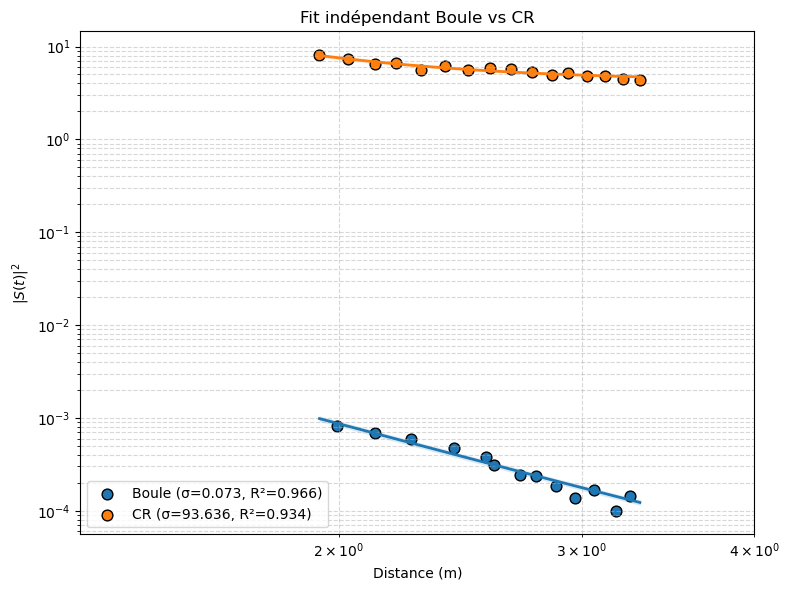

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import glob
from radar import RadarMesure

# -------------------------
# Paramètres
# -------------------------
c = 299792458
f = 13e9
lambdaa = c / f
pad_factor = 4

# RCS de référence
r_cr = 0.3302  # rayon de la sphère CR en mètres
sigmacr_CR = (4 * np.pi * r_cr**4) / (3 * lambdaa**2)
sigmacr_boule = 0.073  # m²

print(f"σᶜʳ (CR, 17 GHz) = {sigmacr_CR:.4f} m²")
print(f"σᶜʳ (Boule) = {sigmacr_boule:.4f} m²")

# -------------------------
# Fonctions utilitaires
# -------------------------
def bin_to_dist(x, pad_factor=1):
    c = 299792458
    B = 2e9
    ramptime = 102400e-9
    fe = 10e6
    df = fe / 1024
    fb = x * df
    dist = fb * c * ramptime / (2 * B)
    return dist / pad_factor

def model(R, ccalib, k, sigma):
    return (ccalib * sigma / (R**4)) + k

def extract_peaks(ri_list, seuil):
    pic = []
    for i in ri_list:
        df = i.df
        peaks, prop = find_peaks(df.copol.loc[1:5], height=seuil)
        if len(peaks) > 0:
            dist = bin_to_dist(peaks[0], pad_factor) + 1
            val = prop['peak_heights'][0]**2
            pic.append((dist, val))
    if not pic:
        return np.array([]), np.array([])
    dfpic = pd.DataFrame(pic).sort_values(by=[0])
    return np.asarray(dfpic[0]), np.asarray(dfpic[1])

def fit_and_evaluate(X, y, sigma, initial_guess=(1,1)):
    """Fit indépendant et calcule R²"""
    popt, pcov = curve_fit(lambda R, c, k: model(R, c, k, sigma), X, y, p0=initial_guess)
    perr = np.sqrt(np.diag(pcov))
    y_pred = model(X, *popt, sigma)
    r2 = r2_score(y, y_pred)
    return popt, perr, y_pred, r2

# -------------------------
# Charger les données
# -------------------------
data_boule = glob.glob('/home/nicolas/Documents/Dku-toolbox/data/caliboule/13*.txt')
data_cr    = glob.glob('/home/nicolas/Documents/Dku-toolbox/data/newcod/13*plud*.txt')
data_boule.sort()
data_cr.sort()

ri_boule = [RadarMesure(f, beta=2, pad_factor=pad_factor) for f in data_boule]
ri_cr    = [RadarMesure(f, beta=2, pad_factor=pad_factor) for f in data_cr]

# -------------------------
# Extraction des pics
# -------------------------
X_boule, y_boule = extract_peaks(ri_boule, 0.001)
X_cr, y_cr = extract_peaks(ri_cr, 0.1)

if len(X_boule) == 0 or len(X_cr) == 0:
    raise RuntimeError("Erreur : un des jeux ne contient pas de pics.")

# -------------------------
# Fit indépendant
# -------------------------
popt_boule, perr_boule, y_pred_boule, r2_boule = fit_and_evaluate(X_boule, y_boule, sigmacr_boule)
popt_cr, perr_cr, y_pred_cr, r2_cr = fit_and_evaluate(X_cr, y_cr, sigmacr_CR)

print(f"\nRésultats fit Boule :")
print(f"  c_calib = {popt_boule[0]:.3e} ± {perr_boule[0]:.1e}")
print(f"  k       = {popt_boule[1]:.3f} ± {perr_boule[1]:.3f}")
print(f"  R²      = {r2_boule:.4f}")

print(f"\nRésultats fit CR :")
print(f"  c_calib = {popt_cr[0]:.3e} ± {perr_cr[0]:.1e}")
print(f"  k       = {popt_cr[1]:.3f} ± {perr_cr[1]:.3f}")
print(f"  R²      = {r2_cr:.4f}")

# -------------------------
# Visualisation
# -------------------------
x_fit = np.linspace(min(np.min(X_boule), np.min(X_cr)),
                    max(np.max(X_boule), np.max(X_cr)), 400)
y_fit_boule = model(x_fit, *popt_boule, sigmacr_boule)
y_fit_cr    = model(x_fit, *popt_cr, sigmacr_CR)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(X_boule, y_boule, color='tab:blue', edgecolors='k', s=60,
           label=f'Boule (σ={sigmacr_boule:.3f}, R²={r2_boule:.3f})')
ax.scatter(X_cr, y_cr, color='tab:orange', edgecolors='k', s=60,
           label=f'CR (σ={sigmacr_CR:.3f}, R²={r2_cr:.3f})')
ax.plot(x_fit, y_fit_boule, color='tab:blue', lw=2)
ax.plot(x_fit, y_fit_cr, color='tab:orange', lw=2)

# Incertitude sur c
ax.fill_between(x_fit,
                model(x_fit, popt_boule[0]-perr_boule[0], popt_boule[1], sigmacr_boule),
                model(x_fit, popt_boule[0]+perr_boule[0], popt_boule[1], sigmacr_boule),
                color='tab:blue', alpha=0.1)
ax.fill_between(x_fit,
                model(x_fit, popt_cr[0]-perr_cr[0], popt_cr[1], sigmacr_CR),
                model(x_fit, popt_cr[0]+perr_cr[0], popt_cr[1], sigmacr_CR),
                color='tab:orange', alpha=0.1)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1.3, 4)
ax.set_xlabel("Distance (m)")
ax.set_ylabel(r"$|S(t)|^2$")
ax.set_title("Fit indépendant Boule vs CR")
ax.grid(True, which='both', linestyle='--', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()


σᶜʳ (CR, 17 GHz) = 160.1229 m²
σᶜʳ (Boule) = 0.0730 m²
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 10 non reconnu dans leg_dict
[WARNING] Mois 7 non reconnu dans leg_dict
[WARNING] Mois 7 non reconnu dans leg_dict
[WARNING] Mois 7 non reconnu dans leg_dict
[WARNING] Mois 7 non reconnu dans leg_dict
[WARNING] Mois 7 non reconnu dans leg_dict
[WARNING] Mois 7 non reconnu dans leg_dict
[WARNING] Mois 7 non reconnu dans leg_dict
[WARNING] Mois 7 non reconnu dans leg_dict
[WARNING] Mois 7 non reconnu dans leg_dict
[WARNING] Mois 7 non reconnu dans leg_dict
[WARNING] Mois 7 non reconnu da

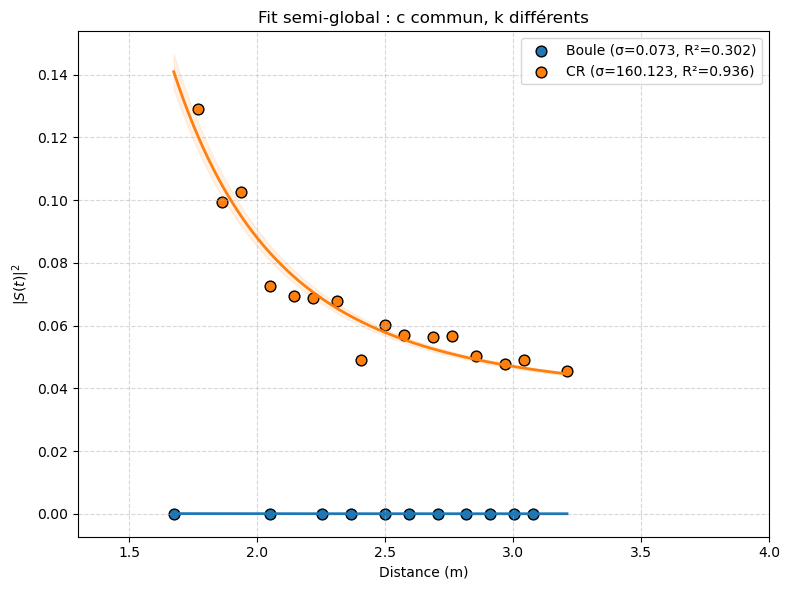

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import glob
from radar import RadarMesure

# -------------------------
# Paramètres
# -------------------------
c = 299792458
f = 17e9
lambdaa = c / f
pad_factor = 4

# RCS de référence
r_cr = 0.3302  # rayon de la sphère CR en mètres
sigmacr_CR = (4 * np.pi * r_cr**4) / (3 * lambdaa**2)
sigmacr_boule = 0.073  # m²

print(f"σᶜʳ (CR, 17 GHz) = {sigmacr_CR:.4f} m²")
print(f"σᶜʳ (Boule) = {sigmacr_boule:.4f} m²")

# -------------------------
# Fonctions utilitaires
# -------------------------
def bin_to_dist(x, pad_factor=1):
    c = 299792458
    B = 2e9
    ramptime = 102400e-9
    fe = 10e6
    df = fe / 1024
    fb = x * df
    dist = fb * c * ramptime / (2 * B)
    return dist / pad_factor

def model(R, ccalib, k, sigma):
    return (ccalib * sigma / (R**4)) + k

def extract_peaks(ri_list, seuil):
    pic = []
    for i in ri_list:
        df = i.df
        peaks, prop = find_peaks(df.copol.loc[1:5], height=seuil)
        if len(peaks) > 0:
            dist = bin_to_dist(peaks[0], pad_factor) + 1
            val = prop['peak_heights'][0]**2
            pic.append((dist, val))
    if not pic:
        return np.array([]), np.array([])
    dfpic = pd.DataFrame(pic).sort_values(by=[0])
    return np.asarray(dfpic[0]), np.asarray(dfpic[1])

def evaluate(X, y, sigma, c, k):
    y_pred = model(X, c, k, sigma)
    r2 = r2_score(y, y_pred)
    return y_pred, r2

# -------------------------
# Charger les données
# -------------------------
data_boule = glob.glob('/home/nicolas/Documents/Dku-toolbox/data/caliboule/17*.txt')
data_cr    = glob.glob('/home/nicolas/Documents/Dku-toolbox/data/newcod/17*.txt')
data_boule.sort()
data_cr.sort()

ri_boule = [RadarMesure(f, beta=2, pad_factor=pad_factor) for f in data_boule]
ri_cr    = [RadarMesure(f, beta=2, pad_factor=pad_factor) for f in data_cr]

# -------------------------
# Extraction des pics
# -------------------------
X_boule, y_boule = extract_peaks(ri_boule, 0.001)
X_cr, y_cr = extract_peaks(ri_cr, 0.1)

if len(X_boule) == 0 or len(X_cr) == 0:
    raise RuntimeError("Erreur : un des jeux ne contient pas de pics.")

# -------------------------
# Fit semi-global (c commun, k séparés)
# -------------------------
def joint_model_k_diff(X_all, ccalib, k_boule, k_cr):
    Xb, Xc = X_all[:len(X_boule)], X_all[len(X_boule):]
    yb = model(Xb, ccalib, k_boule, sigmacr_boule)
    yc = model(Xc, ccalib, k_cr, sigmacr_CR)
    return np.concatenate([yb, yc])

# Données combinées
X_all = np.concatenate([X_boule, X_cr])
y_all = np.concatenate([y_boule, y_cr])

# Fit
initial_guess = [1, 1, 1]  # [c_calib, k_boule, k_cr]
popt, pcov = curve_fit(lambda X, c, kb, kc: joint_model_k_diff(X, c, kb, kc),
                       X_all, y_all, p0=initial_guess)

ccalib, k_boule, k_cr = popt
perr = np.sqrt(np.diag(pcov))

print(f"\nRésultats fit semi-global :")
print(f"  c_calib = {ccalib:.3e} ± {perr[0]:.1e}")
print(f"  k_boule = {k_boule:.3f} ± {perr[1]:.3f}")
print(f"  k_CR    = {k_cr:.3f} ± {perr[2]:.3f}")

# -------------------------
# Évaluation séparée
# -------------------------
y_pred_boule, r2_boule = evaluate(X_boule, y_boule, sigmacr_boule, ccalib, k_boule)
y_pred_cr, r2_cr = evaluate(X_cr, y_cr, sigmacr_CR, ccalib, k_cr)

print(f"\nÉvaluation séparée :")
print(f"  Boule : R² = {r2_boule:.4f}")
print(f"  CR    : R² = {r2_cr:.4f}")

# -------------------------
# Visualisation
# -------------------------
x_fit = np.linspace(min(np.min(X_boule), np.min(X_cr)),
                    max(np.max(X_boule), np.max(X_cr)), 400)
y_fit_boule = model(x_fit, ccalib, k_boule, sigmacr_boule)
y_fit_cr    = model(x_fit, ccalib, k_cr, sigmacr_CR)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(X_boule, y_boule, color='tab:blue', edgecolors='k', s=60,
           label=f'Boule (σ={sigmacr_boule:.3f}, R²={r2_boule:.3f})')
ax.scatter(X_cr, y_cr, color='tab:orange', edgecolors='k', s=60,
           label=f'CR (σ={sigmacr_CR:.3f}, R²={r2_cr:.3f})')
ax.plot(x_fit, y_fit_boule, color='tab:blue', lw=2)
ax.plot(x_fit, y_fit_cr, color='tab:orange', lw=2)

# Incertitude sur c
ax.fill_between(x_fit,
                model(x_fit, ccalib - perr[0], k_boule, sigmacr_boule),
                model(x_fit, ccalib + perr[0], k_boule, sigmacr_boule),
                color='tab:blue', alpha=0.1)
ax.fill_between(x_fit,
                model(x_fit, ccalib - perr[0], k_cr, sigmacr_CR),
                model(x_fit, ccalib + perr[0], k_cr, sigmacr_CR),
                color='tab:orange', alpha=0.1)

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim(1.3, 4)
ax.set_xlabel("Distance (m)")
ax.set_ylabel(r"$|S(t)|^2$")
ax.set_title("Fit semi-global : c commun, k différents")
ax.grid(True, which='both', linestyle='--', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()
